# Lab 3 – Task 3: Scaling

Scaling alters the size of an image by stretching or shrinking it.

The transformation matrix is:

$$T = \begin{bmatrix} s_x & 0 & 0 \\ 0 & s_y & 0 \end{bmatrix}$$

where $s_x$ and $s_y$ are the scaling factors along x and y axes.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Load image (replace path with 'lena.png' if available)
image = cv2.imread('pic.png')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
h, w = image.shape[:2]
print(f'Original image shape: {image.shape}')

Original image shape: (360, 360, 3)


## Original Example – Scale 2×

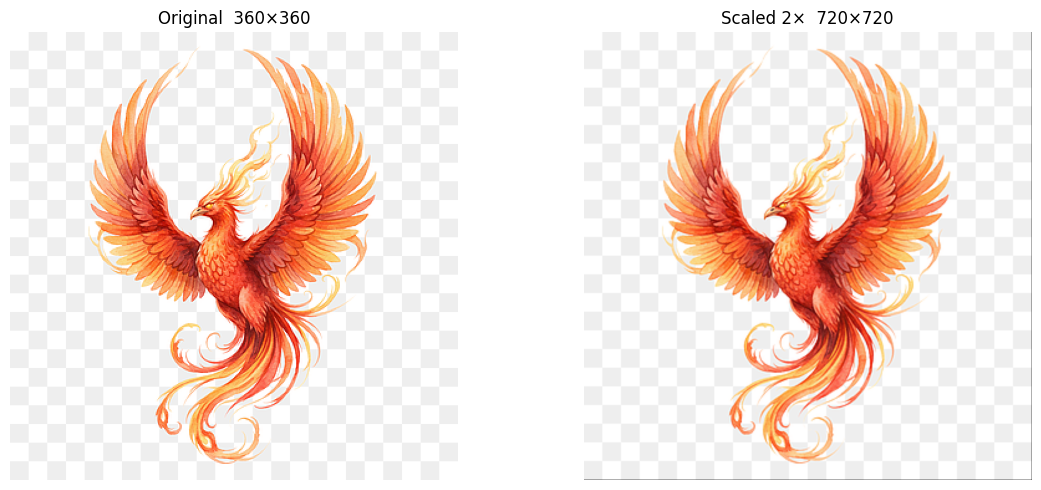

Scaled image shape: (720, 720, 3)


In [3]:
# Original example from the lab
Factor = 2
scaling_matrix = cv2.getRotationMatrix2D((0, 0), 0, Factor)
scaled_image = cv2.warpAffine(image, scaling_matrix, (w * Factor, h * Factor))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(image_rgb)
axes[0].set_title(f'Original  {w}×{h}')
axes[0].axis('off')

axes[1].imshow(cv2.cvtColor(scaled_image, cv2.COLOR_BGR2RGB))
axes[1].set_title(f'Scaled 2×  {w*Factor}×{h*Factor}')
axes[1].axis('off')

plt.tight_layout()
plt.show()
print(f'Scaled image shape: {scaled_image.shape}')

## Task 3.1 – Scale by Different Factors (0.5, 1.5, etc.)

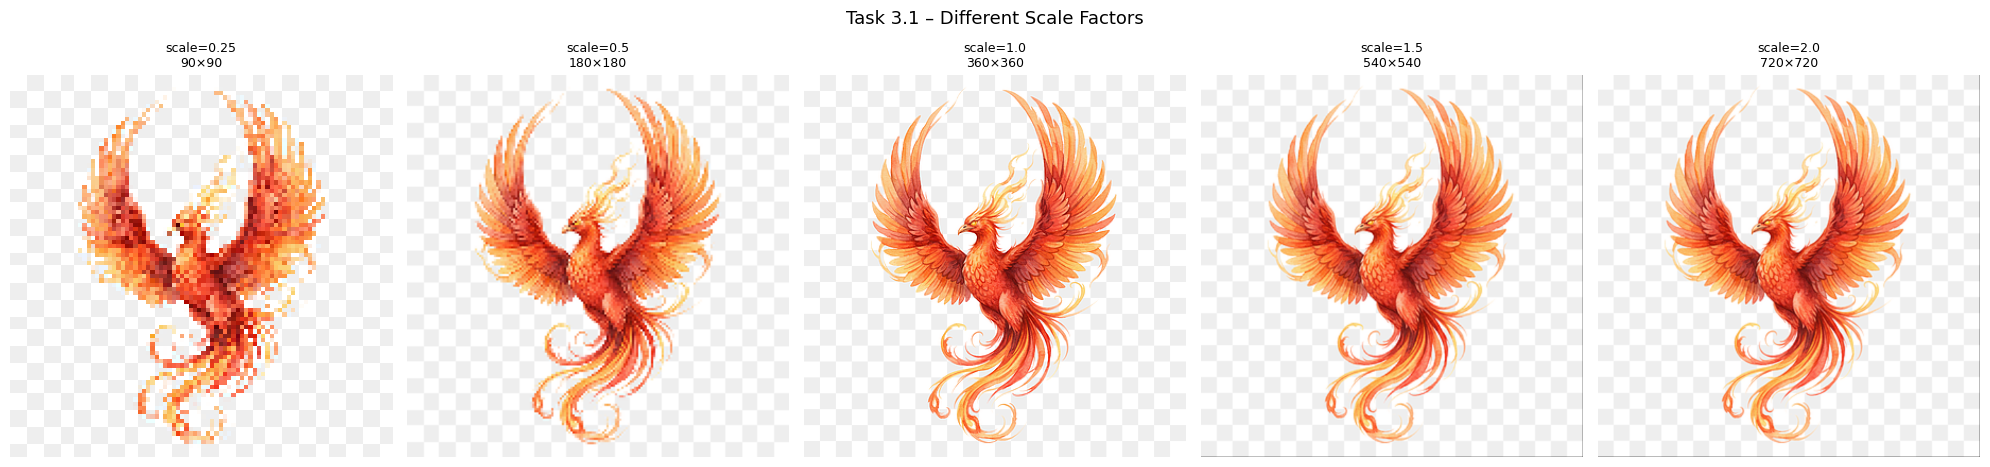

In [4]:
factors = [0.25, 0.5, 1.0, 1.5, 2.0]

fig, axes = plt.subplots(1, len(factors), figsize=(20, 5))

for idx, f in enumerate(factors):
    M = cv2.getRotationMatrix2D((0, 0), 0, f)
    new_w = max(1, int(w * f))
    new_h = max(1, int(h * f))
    result = cv2.warpAffine(image, M, (new_w, new_h))
    axes[idx].imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    axes[idx].set_title(f'scale={f}\n{new_w}×{new_h}', fontsize=9)
    axes[idx].axis('off')

plt.suptitle('Task 3.1 – Different Scale Factors', fontsize=13)
plt.tight_layout()
plt.show()

## Task 3.2 – Extreme Scaling (5×, 8×, 10×, 20×)

Extreme upscaling uses the default **bilinear interpolation** inside `warpAffine`. Each original pixel is spread over a large area; OpenCV interpolates between neighbours, which blurs and pixelates the result.

In [5]:
extreme_factors = [5, 8, 10, 20]
os.makedirs('output', exist_ok=True)

for f in extreme_factors:
    M = cv2.getRotationMatrix2D((0, 0), 0, f)
    new_w, new_h = w * f, h * f
    result = cv2.warpAffine(image, M, (new_w, new_h))
    filename = f'output/scaled_{f}x.png'
    cv2.imwrite(filename, result)
    print(f'scale={f:2d}×  output size: {result.shape[1]}×{result.shape[0]}  saved → {filename}')

scale= 5×  output size: 1800×1800  saved → output/scaled_5x.png
scale= 8×  output size: 2880×2880  saved → output/scaled_8x.png
scale=10×  output size: 3600×3600  saved → output/scaled_10x.png
scale=20×  output size: 7200×7200  saved → output/scaled_20x.png


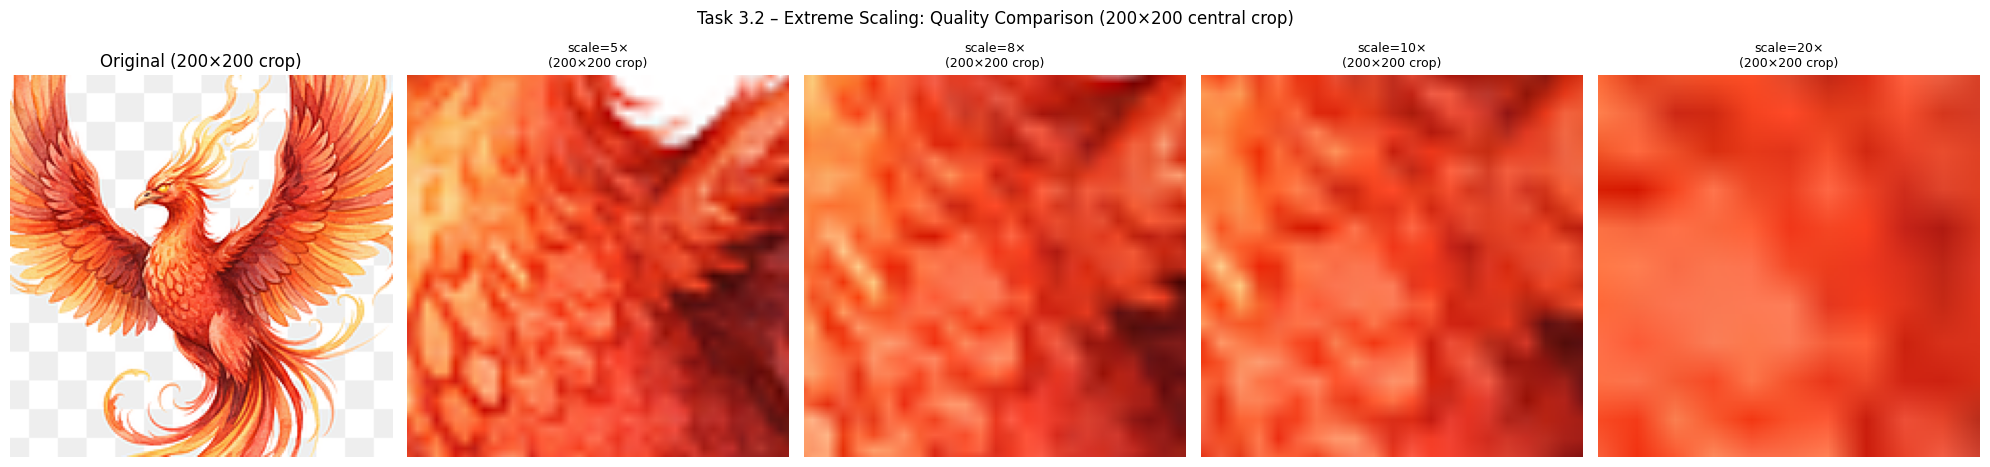

In [6]:
# Display a central crop to see quality degradation clearly
fig, axes = plt.subplots(1, len(extreme_factors) + 1, figsize=(20, 5))

# Show original at its native resolution via a crop
crop_size = 200
cy, cx = h // 2, w // 2
orig_crop = image_rgb[cy - crop_size//2 : cy + crop_size//2,
                      cx - crop_size//2 : cx + crop_size//2]
axes[0].imshow(orig_crop)
axes[0].set_title('Original (200×200 crop)')
axes[0].axis('off')

for idx, f in enumerate(extreme_factors):
    result = cv2.imread(f'output/scaled_{f}x.png')
    result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    # Crop the same logical region (now f× bigger)
    ry = (cy * f) - crop_size // 2
    rx = (cx * f) - crop_size // 2
    crop = result_rgb[ry : ry + crop_size, rx : rx + crop_size]
    axes[idx + 1].imshow(crop)
    axes[idx + 1].set_title(f'scale={f}×\n(200×200 crop)', fontsize=9)
    axes[idx + 1].axis('off')

plt.suptitle('Task 3.2 – Extreme Scaling: Quality Comparison (200×200 central crop)', fontsize=12)
plt.tight_layout()
plt.show()

## Discussion – Impact of Extreme Scaling on Image Quality

| Scale | Observation |
|-------|-------------|
| 0.25× | Significant detail loss; many pixels are merged. |
| 0.5×  | Noticeable blur; fine details disappear. |
| 1.5×  | Slight softness; overall quality still acceptable. |
| 2×    | Mild blurring; individual pixels start to be visible on screen. |
| 5×    | Clear pixel blocks and blurring visible. |
| 8×    | Strong pixelation; smooth gradients become blocky. |
| 10×   | Heavy pixelation; original content hard to distinguish at fine detail. |
| 20×   | Extreme pixelation; each original pixel is a 20×20 block. Image looks like mosaic. |

**Why this happens:**  
`warpAffine` with default bilinear interpolation estimates new pixel values by blending the 4 nearest neighbours in the source. For large upscaling, each source pixel covers a large output region; blending only 4 neighbours cannot recover high-frequency detail that was never stored. The result is a smooth but blurry / blocky image.